In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install yfinance --upgrade --no-cache-dir
from pandas_datareader import data as pdr
import yfinance as yf
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
yf.pdr_override()


In [ ]:
\stock= input("Enter Stock name: ")

Enter Stock name: AAPL


In [ ]:
extension = ".csv"


csv = stock + extension

In [ ]:
df_full = pdr.get_data_yahoo(stock, start="2022-01-01",end = "2022-10-31").reset_index()


[*********************100%%**********************]  1 of 1 completed


In [ ]:
df_full.to_csv(csv,index=False)
df_full.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,177.830002,182.880005,177.710007,182.009995,179.953888,104487900
1,2022-01-04,182.630005,182.940002,179.119995,179.699997,177.669998,99310400
2,2022-01-05,179.610001,180.169998,174.639999,174.919998,172.943985,94537600
3,2022-01-06,172.699997,175.300003,171.639999,172.000000,170.056976,96904000
4,2022-01-07,172.889999,174.139999,171.029999,172.169998,170.225067,86709100


In [ ]:
df= df_full.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1500)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-5).minimize(self.cost)
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest,
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 10
skip = 1
batch_size = 32
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip,
              batch_size = batch_size)
agent.train(iterations =10, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
<ipython-input-7-85170346842b>:22: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
<ipython-input-7-85170346842b>:23: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed, self.action_size)


epoch: 10, total rewards: -252.470032.3, cost: 0.010869, total money: 7506.040009


In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 182.009995, total balance 9817.990005
day 1, sell 1 unit at price 179.699997, investment -1.269160 %, total balance 9997.690002,
day 6: buy 1 unit at price 175.080002, total balance 9822.610001
day 7: buy 1 unit at price 175.529999, total balance 9647.080002
day 8, sell 1 unit at price 172.190002, investment -1.650674 %, total balance 9819.270004,
day 10: buy 1 unit at price 169.800003, total balance 9649.470001
day 11: buy 1 unit at price 166.229996, total balance 9483.240005
day 17, sell 1 unit at price 159.220001, investment -9.291858 %, total balance 9642.460007,
day 19, sell 1 unit at price 174.779999, investment 2.932860 %, total balance 9817.240005,
day 20, sell 1 unit at price 174.610001, investment 5.041211 %, total balance 9991.850006,
day 23: buy 1 unit at price 172.389999, total balance 9819.460007
day 24: buy 1 unit at price 171.660004, total balance 9647.800003
day 25: buy 1 unit at price 174.830002, total balance 9472.970001
day 26, sell 1 unit

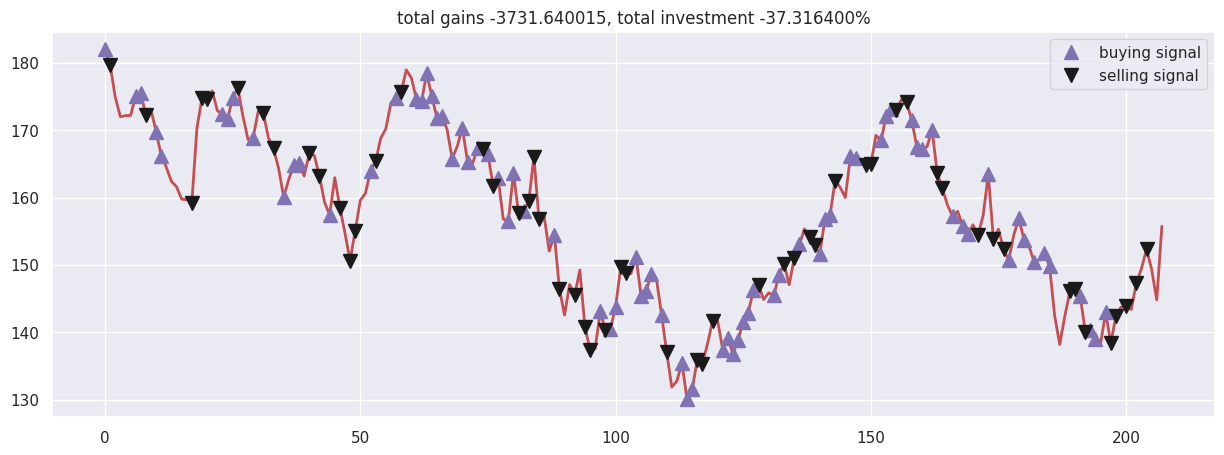

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming you have the true values and predicted values
true_values = np.array(df['Close'][1:])
predicted_values = np.array([initial_money] + [initial_money + action for action in agent.memory[:, 2]])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_values, predicted_values)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, predicted_values)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

TypeError: ignored

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
# Generating some synthetic data
np.random.seed(0)
X = np.random.rand(100, 1) * 10
y = 2 * X + 1 + np.random.randn(100, 1) * 2
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Creating and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
# Making predictions on the test set
y_pred = model.predict(X_test)
# Calculating the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 1.602910966850666
